In [ ]:
#!pip install --user pytorch-pretrained-bert
#!pip install --user spacy ftfy==4.4.3
#!python  -m spacy download --user en
#!pip install --user sklearn
#! pip install --user apex
#! pip install apex
#!pip install fastai

In [ ]:
#!git clone https://github.com/NVIDIA/apex.git

In [1]:
import sys
sys.path.append('/home/bhavanisinghak/capstone')
from scipy import interp
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,30)

In [3]:
from pytorch_pretrained_bert.tokenization import BertTokenizer, WordpieceTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTraining,  BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification
import torch.nn as nn
from pytorch_pretrained_bert.modeling import BertPreTrainedModel
from pathlib import Path
import torch
import re
from torch import Tensor
from torch.nn import BCEWithLogitsLoss
from fastai.text import Tokenizer, Vocab
import pandas as pd
import collections
import os
import pdb
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import roc_curve, auc


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from pytorch_pretrained_bert.optimization import BertAdam

In [4]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
DATA_PATH=Path('./')
DATA_PATH.mkdir(exist_ok=True)

PATH=Path('./tmp')
PATH.mkdir(exist_ok=True)

CLAS_DATA_PATH=PATH/'class'
CLAS_DATA_PATH.mkdir(exist_ok=True)

model_state_dict = None

# BERT_PRETRAINED_PATH = Path('../trained_model/')
BERT_PRETRAINED_PATH = Path('/home/bhavanisinghak/capstone/uncased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../complaints/bert/pretrained-weights/cased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../complaints/bert/pretrained-weights/uncased_L-24_H-1024_A-16/')


BERT_FINETUNED_WEIGHTS = Path('./uncased_L-12_H-768_A-12/')

PYTORCH_PRETRAINED_BERT_CACHE = BERT_PRETRAINED_PATH/'cache/'
PYTORCH_PRETRAINED_BERT_CACHE.mkdir(exist_ok=True)

output_model_file = os.path.join(BERT_FINETUNED_WEIGHTS, "pytorch_model.bin")

# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)


## Model Parameters

In [6]:
args = {
    "train_size": -1,
    "val_size": -1,
    "full_data_dir": DATA_PATH,
    "data_dir": PATH,
    "task_name": "diag_proc_multilabel",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": CLAS_DATA_PATH/'output',
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 32,
    "eval_batch_size": 32,
    "learning_rate": 3e-5,
    "num_train_epochs": 4.0,
    "warmup_proportion": 0.1,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "loss_scale": 128
}

###  Model Class

In [7]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels=2):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

## Data representation class

In [8]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [9]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError() 

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

In [10]:
class MultiLabelTextProcessor(DataProcessor):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.labels = None
    
    
    def get_train_examples(self, data_dir, size=-1):
        filename = 'train.csv'
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, filename)))
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df, "train")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df.sample(size), "train")
        
    def get_dev_examples(self, data_dir, size=-1):
        """See base class."""
        filename = 'val.csv'
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df, "dev")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df.sample(size), "dev")
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        data_df = pd.read_csv(os.path.join(data_dir, data_file_name))
#         data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
        if size == -1:
            return self._create_examples(data_df, "test")
        else:
            return self._create_examples(data_df.sample(size), "test")

    def get_labels(self):
        """See base class."""
        if self.labels == None:
            self.labels = list(pd.read_csv(os.path.join(self.data_dir, "classes.txt"),header=None)[0].values)
        return self.labels

    def _create_examples(self, df, set_type, labels_available=True):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, row) in enumerate(df.values):
            guid = row[0]
            text_a = row[1]
            if labels_available:
                labels = row[2:]
            else:
                labels = []
            examples.append(
                InputExample(guid=guid, text_a=text_a, labels=labels))
        return examples
        

In [11]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(float(label))

#         label_id = label_map[example.label]
        if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features

In [12]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

## Metric functions

In [13]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def accuracy_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
#     return ((y_pred>thresh)==y_true.byte()).float().mean().item()
    return np.mean(((y_pred>thresh)==y_true.byte()).float().cpu().numpy(), axis=1).sum()


def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True):
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean().item()

## Training warmup 

In [14]:
def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [15]:
processors = {
    "diag_proc_multilabel": MultiLabelTextProcessor
}

# Setup GPU parameters

if args["local_rank"] == -1 or args["no_cuda"]:
    device = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")
    n_gpu = torch.cuda.device_count()
#     n_gpu = 1
else:
    torch.cuda.set_device(args['local_rank'])
    device = torch.device("cuda", args['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args['local_rank'] != -1), args['fp16']))

04/02/2019 00:22:24 - INFO - __main__ -   device: cuda n_gpu: 4, distributed training: False, 16-bits training: False


In [16]:
args['train_batch_size'] = int(args['train_batch_size'] / args['gradient_accumulation_steps'])

In [17]:
random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
if n_gpu > 0:
    torch.cuda.manual_seed_all(args['seed'])

In [18]:
task_name = args['task_name'].lower()

if task_name not in processors:
    raise ValueError("Task not found: %s" % (task_name))

In [19]:
processor = processors[task_name](args['data_dir'])
label_list = processor.get_labels()
num_labels = len(label_list)

In [20]:
label_list

[4019,
 4280,
 42731,
 41401,
 5849,
 25000,
 2724,
 51881,
 5990,
 53081,
 9904,
 3893,
 3961,
 9672,
 9604,
 966,
 9671,
 9955,
 8856,
 3891]

In [21]:
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

04/02/2019 00:22:33 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file /home/bhavanisinghak/capstone/uncased_L-12_H-768_A-12/vocab.txt


In [27]:
train_examples = None
num_train_steps = None
if args['do_train']:
    train_examples = processor.get_train_examples(args['full_data_dir'], size=args['train_size'])
#     train_examples = processor.get_train_examples(args['data_dir'], size=args['train_size'])
    num_train_steps = int(
        len(train_examples) / args['train_batch_size'] / args['gradient_accumulation_steps'] * args['num_train_epochs'])


04/02/2019 00:24:51 - INFO - __main__ -   LOOKING AT ./train.csv


In [23]:
# Prepare model
def get_model():
#     pdb.set_trace()
    if model_state_dict:
        model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels, state_dict=model_state_dict)
        print("yes")
    #else:
        #model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels)
    return model

model = get_model()
if args['fp16']:
    model.half()
model.to(device)
if args['local_rank'] != -1:
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    model = DDP(model)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

04/02/2019 00:23:44 - INFO - pytorch_pretrained_bert.modeling -   loading archive file /home/bhavanisinghak/capstone/uncased_L-12_H-768_A-12 from cache at /home/bhavanisinghak/capstone/uncased_L-12_H-768_A-12
04/02/2019 00:23:44 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



yes


In [24]:
model

DataParallel(
  (module): BertForMultiLabelSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                

In [28]:
from torch.optim.lr_scheduler import _LRScheduler, Optimizer

class CyclicLR(object):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `batch_step` should be called after a batch has been used for training.
    To resume training, save `last_batch_iteration` and use it to instantiate `CycleLR`.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for eachparam groups.
            Default: 0.001
        max_lr (float or list): Upper boundaries in the cycle for
            each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function. Default: 0.006
        step_size (int): Number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch. Default: 2000
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        last_batch_iteration (int): The index of the last batch. Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         scheduler.batch_step()
        >>>         train_batch(...)
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

#         if not isinstance(optimizer, Optimizer):
#             raise TypeError('{} is not an Optimizer'.format(
#                 type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [29]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
t_total = num_train_steps
if args['local_rank'] != -1:
    t_total = t_total // torch.distributed.get_world_size()
if args['fp16']:
    try:
        from apex.optimizers import FP16_Optimizer
        from apex.optimizers import FusedAdam
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

    optimizer = FusedAdam(optimizer_grouped_parameters,
                          lr=args['learning_rate'],
                          bias_correction=False,
                          max_grad_norm=1.0)
    if args['loss_scale'] == 0:
        optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
    else:
        optimizer = FP16_Optimizer(optimizer, static_loss_scale=args['loss_scale'])

else:
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=args['learning_rate'],
                         warmup=args['warmup_proportion'],
                         t_total=t_total)

scheduler = CyclicLR(optimizer, base_lr=2e-5, max_lr=5e-5, step_size=2500, last_batch_iteration=0)

In [30]:
# Eval Fn
eval_examples = processor.get_dev_examples(args['data_dir'], size=args['val_size'])
def eval():
    global label_list
    args['output_dir'].mkdir(exist_ok=True)

    
    eval_features = convert_examples_to_features(
        eval_examples, label_list, args['max_seq_length'], tokenizer)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in eval_features], dtype=torch.float)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args['eval_batch_size'])
    
    all_logits = None
    all_labels = None
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    avg_roc_auc=0
    nb_eval_steps, nb_eval_examples = 0, 0
    for input_ids, input_mask, segment_ids, label_ids in eval_dataloader:
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)

#         logits = logits.detach().cpu().numpy()
#         label_ids = label_ids.to('cpu').numpy()
#         tmp_eval_accuracy = accuracy(logits, label_ids)
        tmp_eval_accuracy = accuracy_thresh(logits, label_ids)
        if all_logits is None:
            all_logits = logits.detach().cpu().numpy()
        else:
            all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
            
        if all_labels is None:
            all_labels = label_ids.detach().cpu().numpy()
        else:    
            all_labels = np.concatenate((all_labels, label_ids.detach().cpu().numpy()), axis=0)
        

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    
#     ROC-AUC calcualation
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    precision=dict()
    recall=dict()
    f1=dict()
    roc_auc = dict()
    
    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
        precision[label_list[i]]=precision_score(all_labels[:,i], all_logits[:,i]>0.5,average='weighted')
        recall[label_list[i]]=recall_score(all_labels[:,i], all_logits[:,i]>0.5, average="weighted")
        f1[label_list[i]]=f1_score(all_labels[:,i], all_logits[:,i]>0.5, average="weighted")
        roc_auc[label_list[i]] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'''.format(label_list[i], roc_auc[label_list[i]]))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig('ROC_curve_eval_top10')
    plt.show()
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_labels):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_labels

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    avg_roc_auc = auc(fpr["macro"], tpr["macro"])
    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,
              'Average f1':sum(f1.values())/len(label_list),
              'Average Roc_AUC':avg_roc_auc,
              'precision':precision,
              'recall':recall,
              'f1_score':f1,
#               'loss': tr_loss/nb_tr_steps,
              'roc_auc': roc_auc  }

    output_eval_file = os.path.join(args['output_dir'], "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
#             writer.write("%s = %s\n" % (key, str(result[key])))
    return result

### Load training data

In [53]:
train_features = convert_examples_to_features(
    train_examples, label_list, args['max_seq_length'], tokenizer)


In [54]:
import time

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [55]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_examples))
logger.info("  Batch size = %d", args['train_batch_size'])
logger.info("  Num steps = %d", num_train_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_ids for f in train_features], dtype=torch.float)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
if args['local_rank'] == -1:
    train_sampler = RandomSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args['train_batch_size'])

03/30/2019 20:39:10 - INFO - __main__ -   ***** Running training *****
03/30/2019 20:39:10 - INFO - __main__ -     Num examples = 808663
03/30/2019 20:39:10 - INFO - __main__ -     Batch size = 32
03/30/2019 20:39:10 - INFO - __main__ -     Num steps = 101082


In [31]:
from tqdm import tqdm_notebook as tqdm

### Train Model

In [57]:
def fit(num_epocs=args['num_train_epochs']):
    global_step = 0
    model.train()
    for i_ in tqdm(range(int(num_epocs)), desc="Epoch"):

        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):

            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                optimizer.backward(loss)
            else:
                loss.backward()

            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
    #             scheduler.batch_step()
                # modify learning rate with special warm up BERT uses
                lr_this_step = args['learning_rate'] * warmup_linear(global_step/t_total, args['warmup_proportion'])
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_this_step
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1

        logger.info('Loss after epoc {}'.format(tr_loss / nb_tr_steps))
        logger.info('Eval after epoc {}'.format(i_+1))
        eval()

In [58]:
#Freeze BERT layers for 1 epoch
#model.freeze_bert_encoder()

In [59]:
#fit(1)

In [60]:
model.module.unfreeze_bert_encoder()

In [61]:
tic()
fit(2)
tac()

HBox(children=(IntProgress(value=0, description='Epoch', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Iteration', max=25271, style=ProgressStyle(description_width='initial')), HTML(value='')))

/home/bhavanisinghak/anaconda3/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

03/31/2019 00:15:05 - INFO - __main__ -   Loss after epoc

HBox(children=(IntProgress(value=0, description='Iteration', max=25271, style=ProgressStyle(description_width='initial')), HTML(value='')))

03/31/2019 04:39:20 - INFO - __main__ -   Loss after epoc 0.2652581709249378
03/31/2019 04:39:20 - INFO - __main__ -   Eval after epoc 2
03/31/2019 04:58:16 - INFO - __main__ -   ***** Running evaluation *****
03/31/2019 04:58:16 - INFO - __main__ -     Num examples = 202166
03/31/2019 04:58:16 - INFO - __main__ -     Batch size = 32
03/31/2019 05:33:26 - INFO - __main__ -   ***** Eval results *****
03/31/2019 05:33:26 - INFO - __main__ -     Average Roc_AUC = 0.9176982617317617
03/31/2019 05:33:26 - INFO - __main__ -     Average f1 = 0.8582039986517719
03/31/2019 05:33:26 - INFO - __main__ -     eval_accuracy = 0.8708796243926205
03/31/2019 05:33:26 - INFO - __main__ -     eval_loss = 0.2826983876674943
03/31/2019 05:33:26 - INFO - __main__ -     f1_score = {4019: 0.7762143579917699, 4280: 0.7913723763558003, 42731: 0.8254560362069431, 41401: 0.8777723106688405, 5849: 0.8295456310233276, 25000: 0.8576852419408665, 2724: 0.914084113195201, 51881: 0.8263012268040383, 5990: 0.85667440314


Time passed: 8hour:52min:37sec


In [39]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = os.path.join(PYTORCH_PRETRAINED_BERT_CACHE, "finetuned_pytorch_model.bin")
torch.save(model_to_save.state_dict(), output_model_file)


In [22]:

# Load a trained model that you have fine-tuned
output_model_file = os.path.join(PYTORCH_PRETRAINED_BERT_CACHE, "finetuned_pytorch_model.bin")
model_state_dict = torch.load(output_model_file)
model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels, state_dict=model_state_dict)
model.to(device)

04/02/2019 00:23:19 - INFO - pytorch_pretrained_bert.modeling -   loading archive file /home/bhavanisinghak/capstone/uncased_L-12_H-768_A-12 from cache at /home/bhavanisinghak/capstone/uncased_L-12_H-768_A-12
04/02/2019 00:23:19 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertForMultiLabelSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwis

In [ ]:
model

### Model Evaluation

03/31/2019 06:15:46 - INFO - __main__ -   ***** Running evaluation *****
03/31/2019 06:15:46 - INFO - __main__ -     Num examples = 202166
03/31/2019 06:15:46 - INFO - __main__ -     Batch size = 32
/home/bhavanisinghak/anaconda3/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


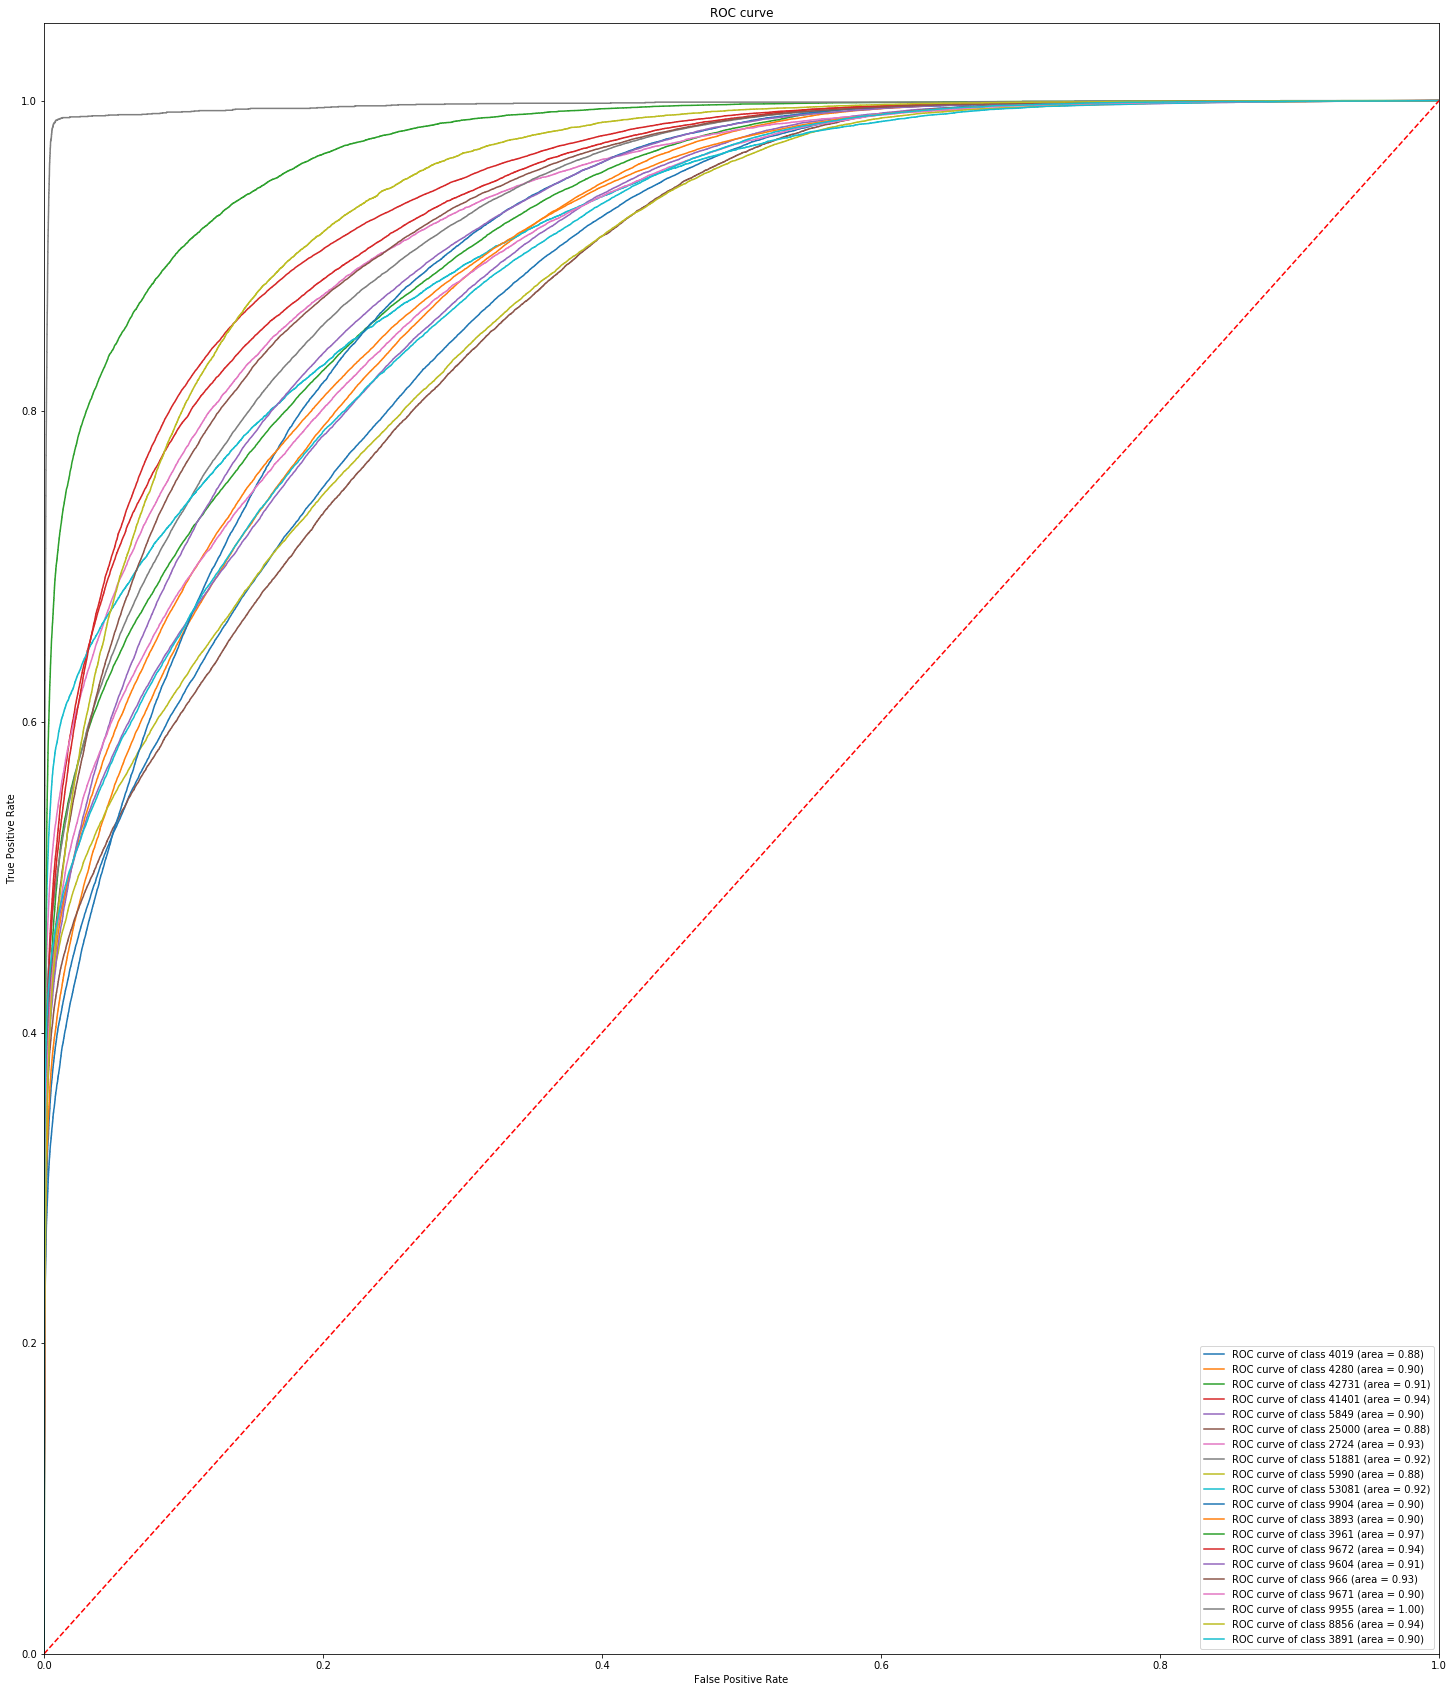

03/31/2019 06:51:12 - INFO - __main__ -   ***** Eval results *****
03/31/2019 06:51:12 - INFO - __main__ -     Average Roc_AUC = 0.9176982617317617
03/31/2019 06:51:12 - INFO - __main__ -     Average f1 = 0.8582039986517719
03/31/2019 06:51:12 - INFO - __main__ -     eval_accuracy = 0.8708796243926205
03/31/2019 06:51:12 - INFO - __main__ -     eval_loss = 0.2826983876674943
03/31/2019 06:51:12 - INFO - __main__ -     f1_score = {4019: 0.7762143579917699, 4280: 0.7913723763558003, 42731: 0.8254560362069431, 41401: 0.8777723106688405, 5849: 0.8295456310233276, 25000: 0.8576852419408665, 2724: 0.914084113195201, 51881: 0.8263012268040383, 5990: 0.8566744031420637, 53081: 0.9295941194473503, 9904: 0.8190760575915141, 3893: 0.7829427072778354, 3961: 0.9448303816752259, 9672: 0.8551659400345394, 9604: 0.8086046221039532, 966: 0.8321137996749426, 9671: 0.8738673290077081, 9955: 0.9949163548972322, 8856: 0.9093184583117426, 3891: 0.8585445056845441}
03/31/2019 06:51:12 - INFO - __main__ -    

In [64]:
result=eval()

In [65]:
del result['Average Roc_AUC']
del result['Average f1']
del result['eval_accuracy']
del result['eval_loss']

In [66]:
df=pd.DataFrame.from_dict(result,orient='index')

In [67]:
df.head()

,4019,4280,42731,41401,5849,25000,2724,51881,5990,53081,9904,3893,3961,9672,9604,966,9671,9955,8856,3891
f1_score,0.776214,0.791372,0.825456,0.877772,0.829546,0.857685,0.914084,0.826301,0.856674,0.929594,0.819076,0.782943,0.944830,0.855166,0.808605,0.832114,0.873867,0.994916,0.909318,0.858545
precision,0.797672,0.815333,0.846885,0.885848,0.860111,0.882443,0.922595,0.839374,0.884593,0.937167,0.839730,0.808099,0.946098,0.859937,0.820131,0.839018,0.886803,0.994896,0.917400,0.885121
recall,0.787165,0.803557,0.835180,0.885114,0.847046,0.876582,0.922885,0.832079,0.875662,0.936819,0.837564,0.781625,0.947286,0.856321,0.812337,0.833642,0.886420,0.994940,0.919927,0.875899
roc_auc,0.882108,0.897643,0.914428,0.936381,0.896947,0.876682,0.929584,0.923637,0.880820,0.915283,0.902714,0.903832,0.971880,0.941677,0.914380,0.928444,0.902404,0.996783,0.942241,0.896090


In [68]:
df1=df.T

In [69]:
df1.to_csv('top10_eval_metrics')

In [4]:
label=['4019_diag','4280_diag','42731_diag','41401_diag','5849_diag','25000_diag','2724_diag','51881_diag','5990_diag','53081_diag','9904_proc','3893_proc','3961_proc','9672_proc','9604_proc','966_proc','9671_proc','9955_proc','8856_proc','3891_proc']
import pandas as pd
df=pd.read_csv('top10_eval_metrics')

In [6]:
column_values = pd.Series(label)

In [7]:
df.insert(loc=0, column='label', value=column_values)

In [9]:
df.to_csv('top10_eval_metrics1', index=False)